In [71]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.metrics import accuracy_score

import sys
sys.path.append('/kaggle/input/tabnet')  # Or wherever you put the files
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from pathlib import Path

# Reusable Functions

In [72]:
def correlation_heatmap(df: pd.DataFrame, x=8, y=6, dpi=100) :
    # First calculate the correlation matrix using pandas
    correlation_matrix = df.corr()
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(x, y), dpi=dpi)
    sns.heatmap(correlation_matrix, 
                annot=True,  # This shows the numbers in each cell
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdBu_r',  # This gives you the red-white-blue colormap similar to the image
                center=0,     # Centers the colormap at 0
                square=True,  # Makes the cells square
                vmin=-1,     # Sets the minimum value for the colormap
                vmax=1)      # Sets the maximum value for the colormap
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Optional: adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [73]:
def remove_outliers(df, columns, n_std=3):
   df_clean = df.copy()
   initial_rows = len(df_clean)
   
   for col in columns:
       z_scores = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
       df_clean = df_clean[abs(z_scores) <= n_std]
   
   rows_removed = initial_rows - len(df_clean)
   return df_clean, rows_removed

def remove_outliers_iqr(df, columns, k=1.5):
   df_clean = df.copy()
   initial_rows = len(df_clean)
   
   for col in columns:
       Q1 = df_clean[col].quantile(0.15)
       Q3 = df_clean[col].quantile(0.85)
       IQR = Q3 - Q1
       
       df_clean = df_clean[~((df_clean[col] < (Q1 - k * IQR)) | 
                            (df_clean[col] > (Q3 + k * IQR)))]
   
   rows_removed = initial_rows - len(df_clean)
   return df_clean, rows_removed

In [74]:
def StandardScale(train_df, test_df, columns_to_ignore):
    
    train_df_to_scale = train_df.drop(columns_to_ignore+['sii'], axis=1)
    test_df_to_scale = test_df.drop(columns_to_ignore, axis=1)
    
    scaler = StandardScaler()
    scaler.fit(train_df_to_scale)
    train_df_scaled = pd.DataFrame(scaler.transform(train_df_to_scale), columns=train_df_to_scale.columns, index=train_df.index)
    test_df_scaled = pd.DataFrame(scaler.transform(test_df_to_scale), columns=train_df_to_scale.columns, index=test_df.index)
    
    for col in columns_to_ignore:
        train_df_scaled[col] = train_df[col]
        test_df_scaled[col] = test_df[col]
    train_df_scaled['sii'] = train_df['sii']
    
    return train_df_scaled, test_df_scaled

In [75]:
def MinMaxScale(df, columns_to_ignore):
    df_to_scale = df.drop(columns_to_ignore, axis=1)
    
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)
    
    for col in columns_to_ignore:
        scaled_df[col] = df[col]
    
    return scaled_df

# Data Gathering

In [76]:
# os.chdir("/kaggle/input/child-mind-institute-problematic-internet-use/")

train_df = pd.read_csv(r"./data/train.csv")
test_df = pd.read_csv(r"./data/test.csv")

# os.chdir("/kaggle/working")

In [77]:
train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
test_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Parquet Files

In [79]:
dirs = [d for d in Path('data/series_train.parquet').iterdir() if d.is_dir()]

def analyse_parquet(parquet_file: Path) :
  return pd.read_parquet(parquet_file)
  
for dir in dirs:
  row_id = str(dir).split("id=")[1]
  parquet_file = next(dir.glob("*.parquet"))

df = analyse_parquet(parquet_file)
df.head()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.947155,-0.054616,0.127157,0.036699,8.424445,0.0,0.500000,4189.000000,44340000000000,1,1,301.0
1,1,0.771766,0.415199,0.013030,0.019078,1.435498,0.0,1.238095,4188.833496,44345000000000,1,1,301.0
2,2,-0.117449,0.415044,0.746269,0.039424,52.555592,0.0,1.976190,4188.666504,44350000000000,1,1,301.0
3,3,-0.412414,0.682195,0.123881,0.054400,6.984442,0.0,2.714286,4188.500000,44355000000000,1,1,301.0
4,4,-0.215429,0.657094,0.498684,0.041109,34.235992,0.0,3.452381,4188.333496,44360000000000,1,1,301.0


In [80]:
df.columns

Index(['step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light',
       'battery_voltage', 'time_of_day', 'weekday', 'quarter',
       'relative_date_PCIAT'],
      dtype='object')

## Removing Rows where accelerometer hasn't been worn

In [81]:
rows_before = len(df)

# Apply filter
df = df[df['non-wear_flag'] != 1]

# Count rows after filtering
rows_after = len(df)

# Calculate number of rows removed
rows_removed = rows_before - rows_after
rows_removed

224884

## Analaysis of Accelerometer data wrt Time of day (hours)

In [82]:
# Convert nanoseconds to hours of day
# First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)
df['time_of_day_hours'].head()

0    12
1    12
2    12
3    12
4    12
Name: time_of_day_hours, dtype: int64

In [83]:
# Create a single DataFrame with means of all desired columns
avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_hours.head()

,time_of_day_hours,X,Y,Z,anglez,light,enmo
0,0,0.155875,0.075954,-0.026142,-5.501348,4.860384,0.003676
1,1,-0.220306,0.161074,-0.295415,-22.773060,4.870170,0.004583
2,2,0.051411,-0.129772,-0.407232,-28.732391,5.687574,0.005606
3,3,-0.089633,0.020714,-0.312193,-25.195501,6.009756,0.003391
4,4,-0.108234,0.102704,-0.075998,-8.072747,7.111255,0.003330


In [84]:
def get_figure(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    ax.set_xticks(range(0, 24))
    ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

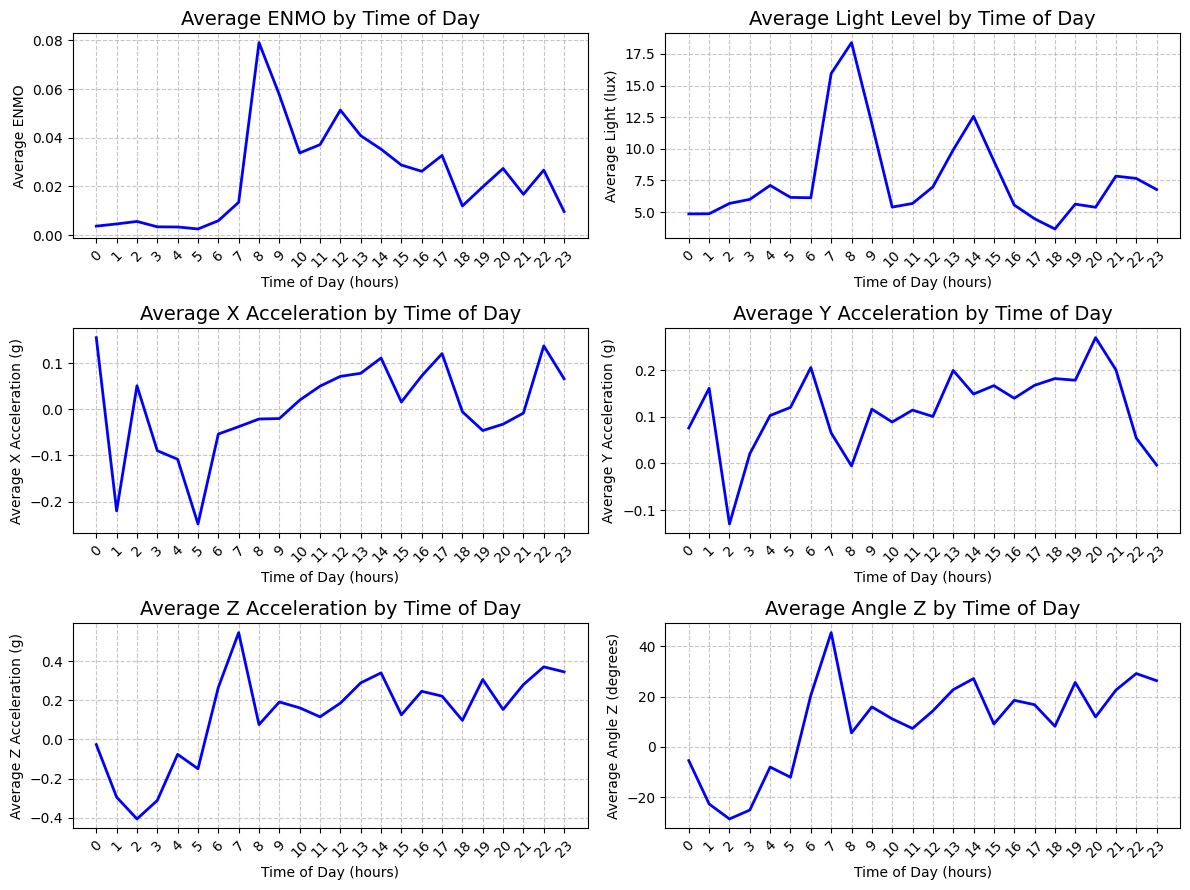

In [85]:
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure(ax1, avg_df_hours['time_of_day_hours'], avg_df_hours['enmo'], 
          'Average ENMO by Time of Day', 
          'Time of Day (hours)', 
          'Average ENMO')

get_figure(ax2, avg_df_hours['time_of_day_hours'], avg_df_hours['light'], 
          'Average Light Level by Time of Day', 
          'Time of Day (hours)', 
          'Average Light (lux)')

get_figure(ax3, avg_df_hours['time_of_day_hours'], avg_df_hours['X'], 
          'Average X Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average X Acceleration (g)')

get_figure(ax4, avg_df_hours['time_of_day_hours'], avg_df_hours['Y'], 
          'Average Y Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Y Acceleration (g)')

get_figure(ax5, avg_df_hours['time_of_day_hours'], avg_df_hours['Z'], 
          'Average Z Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Z Acceleration (g)')

get_figure(ax6, avg_df_hours['time_of_day_hours'], avg_df_hours['anglez'], 
          'Average Angle Z by Time of Day', 
          'Time of Day (hours)', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

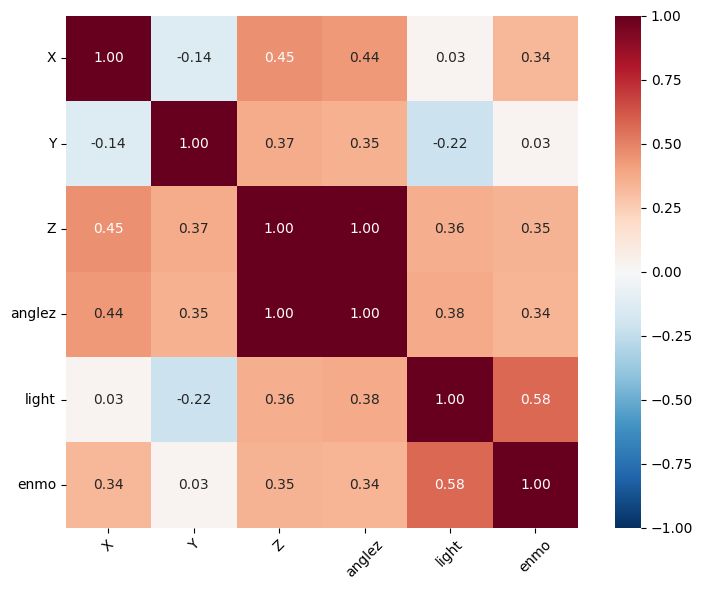

In [86]:
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_hours.drop('time_of_day_hours', axis=1))

In [87]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['X', 'Y', 'Z', 'anglez', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
flat_df = flat_df.reindex(sorted(flat_df.columns), axis=1)

flat_df

,X_0,X_1,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,...,light_21,light_22,light_23,light_3,light_4,light_5,light_6,light_7,light_8,light_9
0,0.155875,-0.220306,0.020144,0.050523,0.071821,0.078394,0.111609,0.016089,0.072837,0.121217,...,7.84535,7.662183,6.786202,6.009756,7.111255,6.164332,6.136124,15.945152,18.387943,11.996333


## Now evaluating the average data per weekday

In [88]:
def get_continuous_sequence(numbers):
    # Convert pandas Series to list if needed
    if hasattr(numbers, 'tolist'):
        numbers = numbers.tolist()
    
    # Now check for empty list
    if not numbers or len(numbers) == 0:
        return []
        
    continuous = [numbers[0]]  # Initialize with first number
    for i in range(1, len(numbers)):
        current = numbers[i]
        prev = numbers[i-1]
        
        # If current number is less than previous, it means we've started a new week
        if current < prev:
            # Add 7 to make it continue from the previous week
            continuous.append(continuous[-1] + (current - prev + 7))
        # If current equals previous, keep the same continuous number
        elif current == prev:
            continuous.append(continuous[-1])
        # If current is greater than previous, add the difference
        else:
            continuous.append(continuous[-1] + (current - prev))
            
    return continuous

In [89]:
df['continuous_weekdays'] = get_continuous_sequence(df['weekday']) 
df['continuous_weekdays'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [90]:
# Create a single DataFrame with means of all desired columns
avg_df_weekday = df.groupby('continuous_weekdays')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_weekday.head()

,continuous_weekdays,X,Y,Z,anglez,light,enmo
0,1,-0.297996,0.213239,-0.192772,-16.366659,11.840536,0.045037
1,2,0.234503,0.176854,0.029267,2.695048,10.292953,0.038168
2,3,-0.263681,0.231898,0.030455,3.274946,8.682956,0.027509
3,4,0.176673,0.031153,0.121483,8.291156,9.622711,0.026469
4,5,0.510846,-0.046606,-0.159633,-11.145076,16.207735,0.080757


In [91]:
def get_figure_weekday(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    # Set x-axis ticks
    # ax.set_xticks(range(len(x)))  # This sets a tick for each x value
    # ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

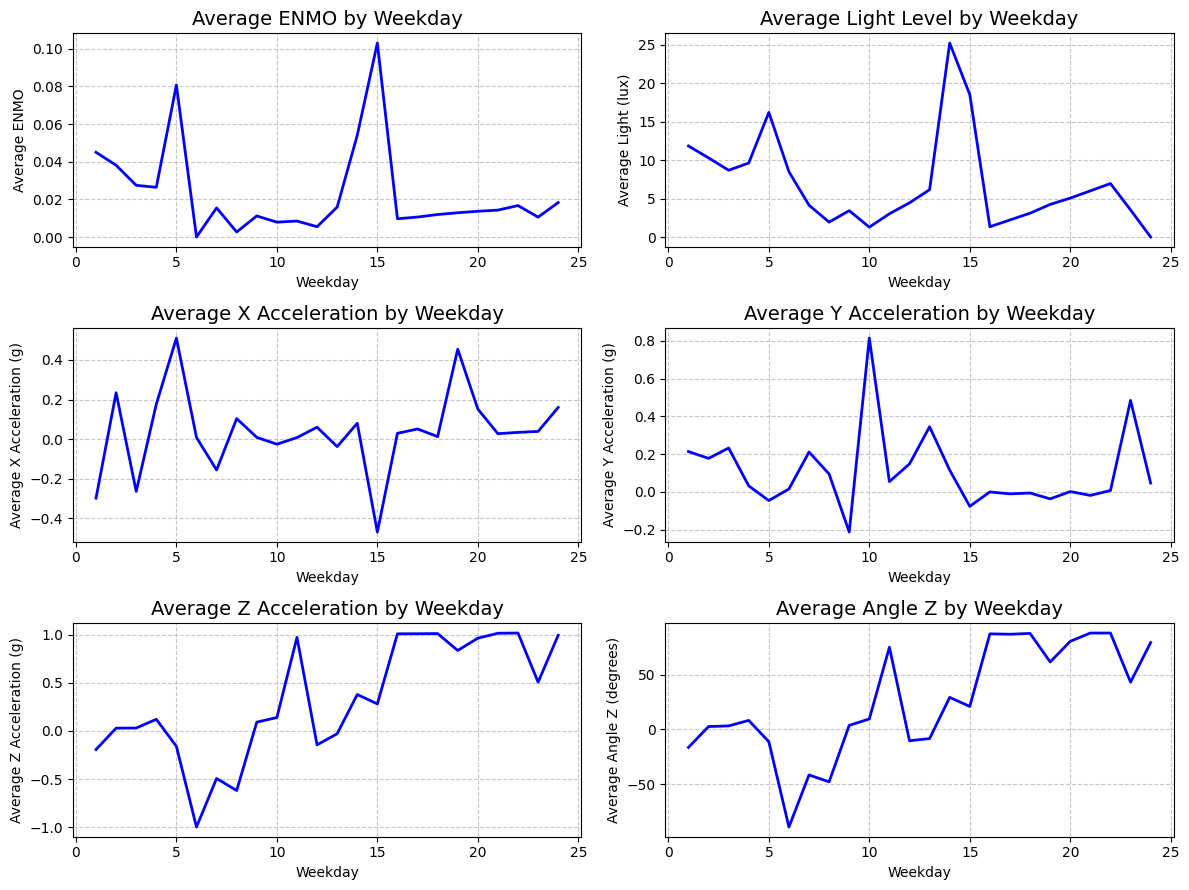

In [92]:
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure_weekday(ax1, avg_df_weekday['continuous_weekdays'], avg_df_weekday['enmo'], 
          'Average ENMO by Weekday', 
          'Weekday', 
          'Average ENMO')

get_figure_weekday(ax2, avg_df_weekday['continuous_weekdays'], avg_df_weekday['light'], 
          'Average Light Level by Weekday', 
          'Weekday', 
          'Average Light (lux)')

get_figure_weekday(ax3, avg_df_weekday['continuous_weekdays'], avg_df_weekday['X'], 
          'Average X Acceleration by Weekday', 
          'Weekday', 
          'Average X Acceleration (g)')

get_figure_weekday(ax4, avg_df_weekday['continuous_weekdays'], avg_df_weekday['Y'], 
          'Average Y Acceleration by Weekday', 
          'Weekday',  
          'Average Y Acceleration (g)')

get_figure_weekday(ax5, avg_df_weekday['continuous_weekdays'], avg_df_weekday['Z'], 
          'Average Z Acceleration by Weekday', 
          'Weekday', 
          'Average Z Acceleration (g)')

get_figure_weekday(ax6, avg_df_weekday['continuous_weekdays'], avg_df_weekday['anglez'], 
          'Average Angle Z by Weekday', 
          'Weekday', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

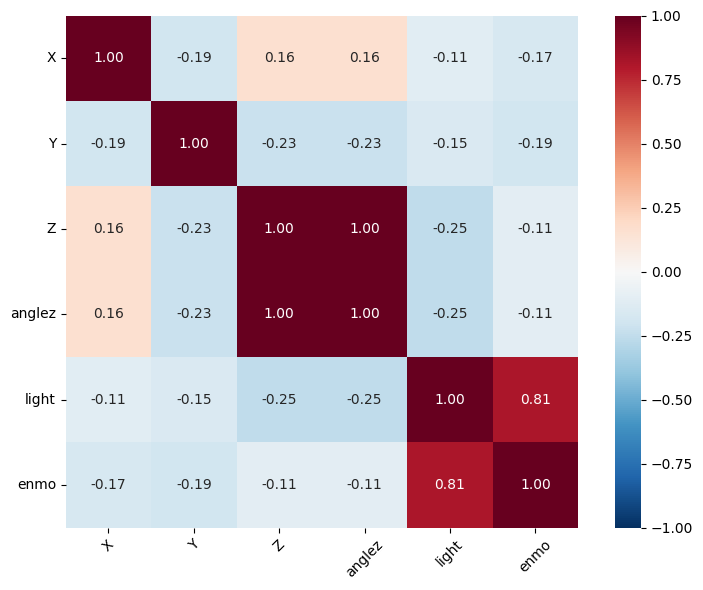

In [93]:
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_weekday.drop('continuous_weekdays', axis=1))

## Conclusions from Analysis

1. Anglez and Z are heavily correlated.
2. X, Y and Z may not be quite as useful as Enmo. Initially discarding the data. If we do not get satisfactory results, we shall consider using X, Y and Z again.
3. Light and Enmo are correlated, but since we're using just one child's Accelerometer data, it might not be the same throughout. Hence, we should ideally keep them both in.

## Flattening Hourly Data

In [94]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['enmo', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_h{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
hourly_flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
# hourly_flat_df = hourly_flat_df.reindex(sorted(hourly_flat_df.columns), axis=1)

hourly_flat_df

,enmo_h0,enmo_h1,enmo_h2,enmo_h3,enmo_h4,enmo_h5,enmo_h6,enmo_h7,enmo_h8,enmo_h9,...,light_h14,light_h15,light_h16,light_h17,light_h18,light_h19,light_h20,light_h21,light_h22,light_h23
0,0.003676,0.004583,0.005606,0.003391,0.00333,0.002519,0.005899,0.013478,0.079089,0.057646,...,12.564425,9.036289,5.561802,4.479136,3.671882,5.632383,5.384964,7.84535,7.662183,6.786202


## Flattening Weekday Data

In [95]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create columns for each unique weekday
for var in ['enmo', 'light']:
    # Get the unique weekdays in sorted order
    unique_weekdays = sorted(avg_df_weekday['continuous_weekdays'].unique())
    
    for weekday in unique_weekdays:
        # Get the value for this weekday
        value = avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday].empty else None
        # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
        col_name = f'{var}_w{weekday}'
        flattened_data[col_name] = [value]

# Create new dataframe
weekday_flat_df = pd.DataFrame(flattened_data)
# Optionally, sort columns to group variables together
# weekday_flat_df = weekday_flat_df.reindex(sorted(weekday_flat_df.columns), axis=1)
weekday_flat_df

,enmo_w1,enmo_w2,enmo_w3,enmo_w4,enmo_w5,enmo_w6,enmo_w7,enmo_w8,enmo_w9,enmo_w10,...,light_w15,light_w16,light_w17,light_w18,light_w19,light_w20,light_w21,light_w22,light_w23,light_w24
0,0.045037,0.038168,0.027509,0.026469,0.080757,0.00007,0.015531,0.002758,0.011258,0.007962,...,18.520447,1.337878,2.21862,3.100655,4.238798,5.062794,6.006053,6.953397,3.530664,0.0


## Creating a combined dataframe

In [96]:
combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
combined_df.head()

,enmo_h0,enmo_h1,enmo_h2,enmo_h3,enmo_h4,enmo_h5,enmo_h6,enmo_h7,enmo_h8,enmo_h9,...,light_w15,light_w16,light_w17,light_w18,light_w19,light_w20,light_w21,light_w22,light_w23,light_w24
0,0.003676,0.004583,0.005606,0.003391,0.00333,0.002519,0.005899,0.013478,0.079089,0.057646,...,18.520447,1.337878,2.21862,3.100655,4.238798,5.062794,6.006053,6.953397,3.530664,0.0


# Function for appending averaged Parquet File into Main CSV File

In [97]:
def extract_id(path):
    return path.split('id=')[1].split('\\')[0]

def get_combined_avg(parquet_file: Path, n: int) :

    if n%50 == 0: print(f"{n} files processed")

    row_id = extract_id(str(parquet_file))
    # print('Analysing data for id: '+row_id)
    
    df = pd.read_parquet(parquet_file)
    
    # Apply filter
    df = df[df['non-wear_flag'] != 1]

    # Convert nanoseconds to hours of day
    # First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
    df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)

    # Create a single DataFrame with means of all desired columns
    avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create 24 columns
    for var in ['enmo', 'light']:
        for hour in range(24):
            # Get the value for this hour
            value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
            # Create new column name (e.g., 'X_1', 'X_2', etc.)
            col_name = f'{var}_h{hour}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    hourly_flat_df = pd.DataFrame(flattened_data)

    df['continuous_weekdays'] = get_continuous_sequence(df['weekday']) 
    
    # Create a single DataFrame with means of all desired columns
    avg_df_weekday = df.groupby('continuous_weekdays')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create columns for each unique weekday
    for var in ['enmo', 'light']:
        # Get the unique weekdays in sorted order
        unique_weekdays = sorted(avg_df_weekday['continuous_weekdays'].unique())
        
        for weekday in unique_weekdays:
            # Get the value for this weekday
            value = avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday].empty else None
            # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
            col_name = f'{var}_w{weekday}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    weekday_flat_df = pd.DataFrame(flattened_data)

    combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
    combined_df['id'] = row_id
    
    return combined_df

In [187]:
def get_stats(parquet_file: Path, n: int):
    if n%50 == 0: 
        print(f"{n} files processed")
        
    row_id = extract_id(str(parquet_file))
    df = pd.read_parquet(parquet_file)
    df = df[df['non-wear_flag'] != 1]

    stats = {}
    for var in ['X', 'Y', 'Z', 'anglez', 'light', 'enmo']:
        stats[f'{var}_mean'] = [df[var].mean()]
        stats[f'{var}_median'] = [df[var].median()]
        stats[f'{var}_std'] = [df[var].std()]
        stats[f'{var}_min'] = [df[var].min()]
        stats[f'{var}_max'] = [df[var].max()]
        stats[f'{var}_skew'] = [df[var].skew()]
        stats[f'{var}_kurtosis'] = [df[var].kurtosis()]
        stats[f'{var}_q25'] = [df[var].quantile(0.25)]
        stats[f'{var}_q75'] = [df[var].quantile(0.75)]
        stats[f'{var}_iqr'] = [df[var].quantile(0.75) - df[var].quantile(0.25)]
        stats[f'{var}_range'] = [df[var].max() - df[var].min()]
        stats[f'{var}_var'] = [df[var].var()]
        stats[f'{var}_mode'] = [df[var].mode().iloc[0] if not df[var].mode().empty else None]
        stats[f'{var}_zero_crossings'] = [((df[var][:-1] * df[var][1:]) < 0).sum()]

    stats_df = pd.DataFrame(stats)
    stats_df['id'] = row_id
    
    return stats_df

In [98]:
dirs = [d for d in Path('data/series_train.parquet').iterdir() if d.is_dir()]
print(f'Total numbers of parquet_files to process: {len(dirs)}')
df_list = []  # Create empty list to store DataFrames
n = 0

for dir in dirs:
    row_id = str(dir).split("id=")[1]
    parquet_file = next(dir.glob("*.parquet"))
    temp_df = get_combined_avg(parquet_file, n)  # Gets single row DataFrame
    df_list.append(temp_df)
    n+=1

# Combine all DataFrames at once
final_df = pd.concat(df_list, ignore_index=True)
final_df = final_df.reindex(sorted(final_df.columns, key=str.lower), axis=1)
final_df.head()

Total numbers of parquet_files to process: 996
0 files processed
50 files processed
100 files processed
150 files processed
200 files processed
250 files processed
300 files processed
350 files processed
400 files processed
450 files processed
500 files processed
550 files processed
600 files processed
650 files processed
700 files processed
750 files processed
800 files processed
850 files processed
900 files processed
950 files processed


C:\Users\User\AppData\Local\Temp\ipykernel_6976\448083431.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(df_list, ignore_index=True)


,enmo_h0,enmo_h1,enmo_h10,enmo_h11,enmo_h12,enmo_h13,enmo_h14,enmo_h15,enmo_h16,enmo_h17,...,light_w9,light_w90,light_w91,light_w92,light_w93,light_w94,light_w95,light_w96,light_w97,light_w99
0,0.020952,0.033222,0.046533,0.043808,0.030952,0.065813,0.045689,0.031533,0.058526,0.053016,...,13.224856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002808,0.008027,0.021365,0.023271,0.038819,0.019645,0.030716,0.026229,0.018902,0.023248,...,24.121109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004010,0.003738,0.049295,0.039044,0.149919,0.073839,0.054163,0.074922,0.045967,0.030919,...,33.663876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.004876,0.004869,0.065006,0.047939,0.047176,0.059867,0.052670,0.047561,0.064359,0.050110,...,13.530785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005384,0.004706,0.061734,0.050658,0.112435,0.126275,0.078224,0.228003,0.173780,0.066350,...,48.232033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
final_df.to_csv('data/avg_parquet.csv')

# Outlier

In [100]:
nan_percentage = (train_df.isna().sum()/len(train_df))*100
print("Percentage of NaN values in each column:\n", nan_percentage)

Percentage of NaN values in each column:
 id                                         0.000000
Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                               35.479798
                                            ...    
SDS-SDS_Total_Raw                         34.116162
SDS-SDS_Total_T                           34.191919
PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
sii                                       30.909091
Length: 82, dtype: float64


In [101]:
columns_to_drop = list(train_df.loc[:, nan_percentage > 70].columns)
columns_to_drop

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-Season',
 'PAQ_A-PAQ_A_Total']

In [102]:
train_df1 = train_df.drop(columns_to_drop, axis=1)
test_df1 = test_df.drop(columns_to_drop, axis=1)

train_df.shape, test_df.shape, train_df1.shape, test_df1.shape

((3960, 82), (20, 59), (3960, 72), (20, 49))

In [103]:
columns_to_drop_for_outlier_removal = ['id',
'Basic_Demos-Enroll_Season',
'Basic_Demos-Sex',
'CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'FGC-FGC_CU_Zone',
'FGC-FGC_PU_Zone',
'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone',
'FGC-FGC_TL_Zone',
'BIA-Season',
'BIA-BIA_Activity_Level_num',
'BIA-BIA_Frame_num',
'PAQ_C-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'PreInt_EduHx-computerinternet_hoursday', 'PCIAT-Season',
'PCIAT-PCIAT_01',
'PCIAT-PCIAT_02',
'PCIAT-PCIAT_03',
'PCIAT-PCIAT_04',
'PCIAT-PCIAT_05',
'PCIAT-PCIAT_06',
'PCIAT-PCIAT_07',
'PCIAT-PCIAT_08',
'PCIAT-PCIAT_09',
'PCIAT-PCIAT_10',
'PCIAT-PCIAT_11',
'PCIAT-PCIAT_12',
'PCIAT-PCIAT_13',
'PCIAT-PCIAT_14',
'PCIAT-PCIAT_15',
'PCIAT-PCIAT_16',
'PCIAT-PCIAT_17',
'PCIAT-PCIAT_18',
'PCIAT-PCIAT_19',
'PCIAT-PCIAT_20',
'sii']

In [104]:
train_df2, removed = remove_outliers_iqr(train_df1, train_df1.drop(columns_to_drop_for_outlier_removal, axis=1).columns)
print("Number of rows removed: ",removed)

Number of rows removed:  227


# Impute

In [105]:
categorical_columns = ['Basic_Demos-Sex',
'FGC-FGC_CU_Zone',
'FGC-FGC_PU_Zone',
'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone',
'FGC-FGC_TL_Zone',
'BIA-BIA_Activity_Level_num',
'BIA-BIA_Frame_num',
'PCIAT-PCIAT_01',
'PCIAT-PCIAT_02',
'PCIAT-PCIAT_03',
'PCIAT-PCIAT_04',
'PCIAT-PCIAT_05',
'PCIAT-PCIAT_06',
'PCIAT-PCIAT_07',
'PCIAT-PCIAT_08',
'PCIAT-PCIAT_09',
'PCIAT-PCIAT_10',
'PCIAT-PCIAT_11',
'PCIAT-PCIAT_12',
'PCIAT-PCIAT_13',
'PCIAT-PCIAT_14',
'PCIAT-PCIAT_15',
'PCIAT-PCIAT_16',
'PCIAT-PCIAT_17',
'PCIAT-PCIAT_18',
'PCIAT-PCIAT_19',
'PCIAT-PCIAT_20',
'PreInt_EduHx-computerinternet_hoursday',
'CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'BIA-Season',
'PAQ_C-Season',
'PCIAT-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'Basic_Demos-Enroll_Season']

In [106]:
columns = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-Season', 'PCIAT-PCIAT_Total']

for col in columns :
    test_df1[col]= None
test_df1 = test_df1[train_df2.drop('sii', axis=1).columns]

missing_cols = set(train_df2.columns) - set(test_df1.columns)
print(list(missing_cols))

['sii']


In [107]:
train_df3 = train_df2.copy()
test_df3 = test_df1.copy()

In [108]:
train_df_cat = train_df2.drop(['id', 'sii'], axis=1)[categorical_columns]
test_df_cat = test_df1.drop(['id'], axis=1)[categorical_columns]

train_df_num = train_df2.drop(categorical_columns+['id', 'sii'], axis=1)
test_df_num = test_df1.drop(categorical_columns+['id'], axis=1)

In [109]:
train_df_cat.columns, train_df_num.columns

(Index(['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone',
        'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
        'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PCIAT-PCIAT_01',
        'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05',
        'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09',
        'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13',
        'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17',
        'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
        'PreInt_EduHx-computerinternet_hoursday', 'CGAS-Season',
        'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
        'BIA-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season',
        'PreInt_EduHx-Season', 'Basic_Demos-Enroll_Season'],
       dtype='object'),
 Index(['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height',
        'Physical-Weight', 'Physical-Dias

In [110]:
knn_imputer = KNNImputer(n_neighbors=5)

knn_imputer.fit(train_df_num)

train_df3[train_df_num.columns] = knn_imputer.transform(train_df_num)
test_df3[test_df_num.columns] = knn_imputer.transform(test_df_num)

for column in train_df_cat.columns:
    mode_value = train_df_cat[column].mode()[0]
    train_df3.fillna({column: mode_value}, inplace=True)
    test_df3.fillna({column: mode_value}, inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_6976\2367350307.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df3.fillna({column: mode_value}, inplace = True)


# Encoding

In [111]:
onehot_columns = ['CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'BIA-Season',
'PAQ_C-Season',
'PCIAT-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'Basic_Demos-Enroll_Season']

In [112]:
train_df3.shape, test_df3.shape

((3733, 72), (20, 71))

In [113]:
train_df4 = train_df3.copy()
test_df4 = test_df3.copy()

for col in onehot_columns:
    dummies = pd.get_dummies(train_df3[col], prefix=col).astype(int)
    test_dummies = pd.get_dummies(test_df3[col], prefix=col).astype(int)
    
    # Add missing columns in test
    missing_cols = set(dummies.columns) - set(test_dummies.columns)
    for c in missing_cols:
        test_dummies[c] = 0

    col_to_drop = dummies.columns[-1]
    dummies = dummies.drop(col_to_drop, axis=1)
    test_dummies = test_dummies.drop(col_to_drop, axis=1)
        
    # Ensure columns are in same order
    test_dummies = test_dummies[dummies.columns]
    
    train_df4 = pd.concat([train_df4, dummies], axis=1)
    test_df4 = pd.concat([test_df4, test_dummies], axis=1)
    train_df4.drop(col, axis=1, inplace=True)
    test_df4.drop(col, axis=1, inplace=True)

In [114]:
train_df4.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-Season_Summer,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer
0,00008ff9,5.0,0,51.0,16.877316,46.0,50.80,61.6,84.0,111.8,...,0,0,1,0,1,0,0,1,0,0
1,000fd460,9.0,0,65.8,14.035590,48.0,46.00,75.0,70.0,122.0,...,0,1,0,0,0,0,1,0,0,1
2,00105258,10.0,1,71.0,16.648696,56.5,75.60,65.0,94.0,117.0,...,0,1,0,0,0,0,1,0,0,1
3,00115b9f,9.0,0,71.0,18.292347,56.0,81.60,60.0,97.0,117.0,...,1,0,0,1,0,0,0,0,0,0
4,0016bb22,18.0,1,64.8,20.713543,68.1,145.78,65.0,74.2,123.8,...,0,0,1,0,0,1,0,0,1,0


In [115]:
test_df4.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-Season_Summer,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer
0,00008ff9,5.0,0,51.0,16.877316,46.0,50.80,60.4,81.4,107.6,...,0,0,1,0,1,0,0,1,0,0
1,000fd460,9.0,0,67.2,14.035590,48.0,46.00,75.0,70.0,122.0,...,0,1,0,0,0,0,1,0,0,1
2,00105258,10.0,1,71.0,16.648696,56.5,75.60,65.0,94.0,117.0,...,0,1,0,0,0,0,1,0,0,1
3,00115b9f,9.0,0,71.0,18.292347,56.0,81.60,60.0,97.0,117.0,...,0,0,0,1,0,0,0,0,0,0
4,0016bb22,18.0,1,64.8,20.713543,68.1,145.78,65.0,74.2,123.8,...,0,0,1,0,0,1,0,0,1,0


# Feature Engineering

In [116]:
fitness_cols = [col for col in train_df4.columns if 'FGC' in col and 'Zone' in col]
physical_cols = [col for col in train_df4.columns if 'Physical' in col]
bia_cols = [col for col in train_df4.columns if 'BIA' in col and 'num' not in col]

In [117]:
def add_features(df) :
    df['age_internet'] = df['Basic_Demos-Age'] * df['PreInt_EduHx-computerinternet_hoursday']
        
    # Aggregate fitness scores
    df['avg_fitness_score'] = df[fitness_cols].mean(axis=1)
    
    # Physical measurements aggregation
    df['physical_composite'] = df[physical_cols].mean(axis=1)
    
    # BIA measurements aggregation
    df['bia_composite'] = df[bia_cols].mean(axis=1)
        
    # Enhanced physical measurements with safety checks
    df['bmi_age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    
    # Safe division for ratios
    df['height_weight_ratio'] = np.where(
        df['Physical-Weight'] > 0,
        df['Physical-Height'] / df['Physical-Weight'],
        0
    )
    
    df['bp_ratio'] = np.where(
        df['Physical-Diastolic_BP'] > 0,
        df['Physical-Systolic_BP'] / df['Physical-Diastolic_BP'],
        0
    )
    
    # Fitness scores
    zone_cols = [col for col in df.columns if 'Zone' in col]
    df['avg_fitness_score'] = df[zone_cols].mean(axis=1)
    
    # BIA features
    df['fat_muscle_ratio'] = np.where(
        df['BIA-BIA_SMM'] > 0,
        df['BIA-BIA_Fat'] / df['BIA-BIA_SMM'],
        0
    )
    
    df.shape
    return df

In [118]:
train_df5 = add_features(train_df4)
test_df5 = add_features(test_df4)

test_df5 = test_df5[train_df5.drop('sii', axis=1).columns]

In [119]:
train_df5.columns

Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM',
       'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_C-PAQ_C_Total',
       'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
       'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
       'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCI

# Scaling

In [120]:
categorical_columns = ['id', 'Basic_Demos-Sex','FGC-FGC_CU_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone','BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num',
'PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05',
'PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10',
'PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15',
'PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19',
'PCIAT-PCIAT_20','PreInt_EduHx-computerinternet_hoursday',
'CGAS-Season_Fall','CGAS-Season_Spring', 'CGAS-Season_Summer', 'Physical-Season_Fall',
'Physical-Season_Spring', 'Physical-Season_Summer',
'Fitness_Endurance-Season_Fall', 'Fitness_Endurance-Season_Spring',
'Fitness_Endurance-Season_Summer', 'FGC-Season_Fall',
'FGC-Season_Spring', 'FGC-Season_Summer', 'BIA-Season_Fall',
'BIA-Season_Spring', 'BIA-Season_Summer', 'PAQ_C-Season_Fall',
'PAQ_C-Season_Spring', 'PAQ_C-Season_Summer', 'PCIAT-Season_Fall',
'PCIAT-Season_Spring', 'PCIAT-Season_Summer', 'SDS-Season_Fall',
'SDS-Season_Spring', 'SDS-Season_Summer', 'PreInt_EduHx-Season_Fall',
'PreInt_EduHx-Season_Spring', 'PreInt_EduHx-Season_Summer',
'Basic_Demos-Enroll_Season_Fall']

In [121]:
(train_df6, test_df6) = StandardScale(train_df5, test_df5, categorical_columns)
train_df6.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_PU,...,PCIAT-Season_Spring,PCIAT-Season_Summer,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,Basic_Demos-Enroll_Season_Fall,sii
count,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,3.733000e+03,...,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,2546.000000
mean,7.899149e-17,-2.250782e-16,-3.054972e-16,6.852274e-17,3.235796e-17,8.108524e-16,-1.092557e-15,2.379262e-16,1.275284e-16,5.995740e-17,...,0.509778,0.163943,0.155639,0.523440,0.159389,0.207072,0.360836,0.203857,0.218055,0.564415
std,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,...,0.499971,0.370274,0.362561,0.499517,0.366088,0.405262,0.480307,0.402918,0.412980,0.758951
min,-1.519982e+00,-4.090380e+00,-2.710480e+00,-2.802234e+00,-2.299041e+00,-3.907064e+00,-4.053588e+00,-4.141373e+00,-1.203901e+00,-9.731027e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.570897e-01,-4.874922e-01,-7.216754e-01,-7.823424e-01,-7.387145e-01,-5.702172e-01,-6.266499e-01,-5.718208e-01,-6.468820e-01,-7.870468e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.182801e-02,-1.396979e-02,-2.275910e-01,-1.373945e-01,-2.838398e-01,-7.160786e-02,-6.103886e-02,-1.256268e-01,-2.012669e-01,-2.288791e-01,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.934337e-01,5.419044e-01,5.453250e-01,8.123090e-01,7.264052e-01,4.078242e-01,5.212078e-01,4.841717e-01,4.671557e-01,3.664997e-01,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,3.369742e+00,3.115396e+00,4.668742e+00,3.009384e+00,4.264907e+00,4.435053e+00,4.680113e+00,4.336313e+00,4.366288e+00,4.608574e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


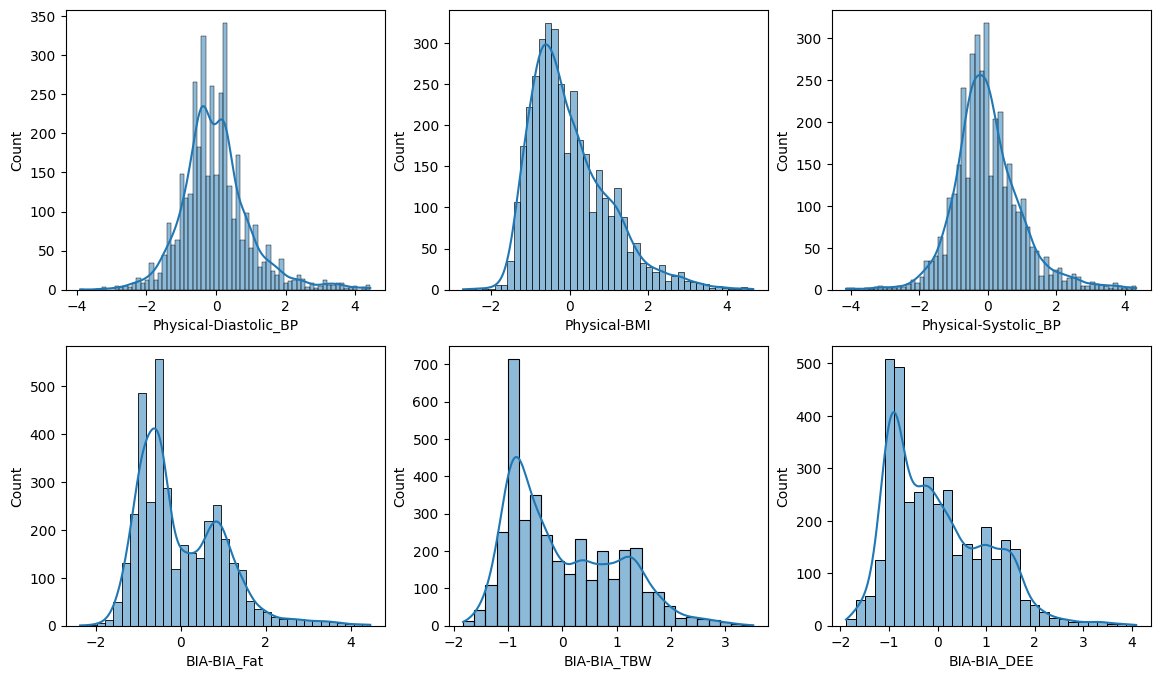

In [122]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=train_df6['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=train_df6['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=train_df6['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=train_df6['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=train_df6['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=train_df6['BIA-BIA_DEE'], ax=ax6)
plt.show()

# Split X and Y

In [123]:
X_temp = train_df6.drop('sii', axis=1)
y_temp = train_df6['sii']

X_temp.shape, y_temp.shape

((3733, 99), (3733,))

In [124]:
X_train, X_cv, y_train, y_cv = train_test_split(X_temp.drop('id', axis=1), y_temp, test_size=0.2, random_state=42)
X_train.shape, X_cv.shape

((2986, 98), (747, 98))

# K-Means

## Calculate Weights   

In [125]:
zero_count = int(train_df6[train_df6['sii'] == 0.0]['sii'].value_counts().values[0])
one_count = int(train_df6[train_df6['sii'] == 1.0]['sii'].value_counts().values[0])
two_count = int(train_df6[train_df6['sii'] == 2.0]['sii'].value_counts().values[0])
three_count = int(train_df6[train_df6['sii'] == 3.0]['sii'].value_counts().values[0])
total = zero_count + one_count + two_count + three_count

zero_count, one_count, two_count, three_count, total

(1504, 672, 345, 25, 2546)

In [126]:
zero_weight = 1/(zero_count/total)
one_weight = 1/(one_count/total)
two_weight = 1/(two_count/total)
three_weight = 1/(three_count/total)

zero_weight, one_weight, two_weight, three_weight

(1.6928191489361704, 3.788690476190476, 7.379710144927536, 101.84)

## Fit

In [127]:
kmeans = KMeans(n_clusters = 4, n_init = 'auto', random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=4, random_state=42)

In [128]:
train_clusters = kmeans.labels_

In [129]:
# Count points per cluster
cluster_counts = pd.Series(train_clusters).value_counts().sort_index()
print("Points per cluster:")
for cluster, count in cluster_counts.items():
   print(f"Cluster {cluster}: {count}")

Points per cluster:
Cluster 0: 449
Cluster 1: 739
Cluster 2: 669
Cluster 3: 1129


In [130]:
cluster_sii_counts = pd.crosstab(train_clusters, y_train)
cluster_sii_counts

sii,0.0,1.0,2.0,3.0
row_0,,,,
0,9,215,208,17
1,283,9,0,0
2,296,308,65,0
3,619,0,0,0


In [131]:
cluster_sii_counts.columns

Index([0.0, 1.0, 2.0, 3.0], dtype='float64', name='sii')

In [132]:
# Get weighted counts for each cluster
cluster_sii_counts = pd.crosstab(train_clusters, y_train)
weighted_counts = cluster_sii_counts * pd.Series({0: zero_weight, 1: one_weight, 2: two_weight, 3: three_weight})

weighted_counts

sii,0.0,1.0,2.0,3.0
row_0,,,,
0,15.235372,814.568452,1534.979710,1731.28
1,479.067819,34.098214,0.000000,0.00
2,501.074468,1166.916667,479.681159,0.00
3,1047.855053,0.000000,0.000000,0.00


In [133]:
# Get cluster mapping based on maximum weighted count
cluster_to_sii_weighted = weighted_counts.idxmax(axis=1)
cluster_to_sii_weighted

row_0
0    3.0
1    0.0
2    1.0
3    0.0
dtype: float64

## Cross Validation

In [134]:
y_cv_predict = np.array([cluster_to_sii_weighted[x] for x in kmeans.predict(X_cv)])

In [135]:
mask = ~y_cv.isna()

accuracy_score(y_cv[mask], y_cv_predict[mask])

0.5996131528046421

In [136]:
k_range = range(2, 30)
accuracies = {}
best_acc = 0
best_k = 2

best_model = None

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
    kmeans.fit(X_train)

    train_clusters = kmeans.labels_
    
    # Get cluster SII mappings
    cluster_sii_counts = pd.crosstab(train_clusters, y_train)
    weighted_counts = cluster_sii_counts * pd.Series({0: zero_weight, 1: one_weight, 2: two_weight, 3: three_weight})

    # Get cluster mapping based on maximum weighted count
    cluster_to_sii_weighted = weighted_counts.idxmax(axis=1)
    
    predictions = np.array([cluster_to_sii_weighted[x] for x in kmeans.predict(X_cv)])
    
    # Calculate accuracy
    mask = ~y_cv.isna()
    acc = accuracy_score(y_cv[mask], predictions[mask])
    accuracies[k] = acc
    print(f'k={k}, accuracy={acc:.3f}')

    if acc>best_acc :
        print(f'best accuracy found = {acc}')
        best_acc = acc
        best_k = k

        best_model = kmeans
        
best_k, best_acc

k=2, accuracy=0.619
best accuracy found = 0.6189555125725339
k=3, accuracy=0.691
best accuracy found = 0.690522243713733
k=4, accuracy=0.600
k=5, accuracy=0.536
k=6, accuracy=0.692
best accuracy found = 0.6924564796905223
k=7, accuracy=0.700
best accuracy found = 0.7001934235976789
k=8, accuracy=0.677
k=9, accuracy=0.793
best accuracy found = 0.793036750483559
k=10, accuracy=0.801
best accuracy found = 0.8007736943907157
k=11, accuracy=0.810
best accuracy found = 0.8104448742746615
k=12, accuracy=0.807
k=13, accuracy=0.809
k=14, accuracy=0.810
k=15, accuracy=0.820
best accuracy found = 0.8201160541586073
k=16, accuracy=0.822
best accuracy found = 0.8220502901353965
k=17, accuracy=0.818
k=18, accuracy=0.805
k=19, accuracy=0.855
best accuracy found = 0.8549323017408124
k=20, accuracy=0.836
k=21, accuracy=0.789
k=22, accuracy=0.783
k=23, accuracy=0.768
k=24, accuracy=0.785
k=25, accuracy=0.791
k=26, accuracy=0.781
k=27, accuracy=0.789
k=28, accuracy=0.762
k=29, accuracy=0.750


(19, 0.8549323017408124)

In [137]:
best_model

KMeans(n_clusters=19, random_state=42)

## Test Predictions

In [138]:
train_clusters.shape, y_train.shape

((2986,), (2986,))

In [139]:
train_clusters = best_model.labels_
    
# Get cluster SII mappings
cluster_sii_counts = pd.crosstab(train_clusters, y_train)
weighted_counts = cluster_sii_counts * pd.Series({0: zero_weight, 1: one_weight, 2: two_weight, 3: three_weight})

In [140]:
weighted_counts

sii,0.0,1.0,2.0,3.0
row_0,,,,
0,15.235372,500.107143,44.278261,0.00
1,113.418883,0.000000,0.000000,0.00
2,523.081117,98.505952,0.000000,0.00
3,113.418883,109.872024,0.000000,0.00
4,140.503989,0.000000,0.000000,0.00
5,225.144947,0.000000,0.000000,0.00
6,50.784574,0.000000,0.000000,0.00
7,0.000000,0.000000,405.884058,1731.28
8,0.000000,0.000000,597.756522,0.00


In [141]:
# Get cluster mapping based on maximum weighted count
cluster_to_sii_weighted = weighted_counts.idxmax(axis=1)
cluster_to_sii_weighted

row_0
0     1.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     3.0
8     2.0
9     0.0
10    1.0
11    0.0
12    1.0
13    2.0
14    0.0
15    0.0
16    0.0
17    0.0
18    2.0
dtype: float64

In [142]:
k_means_test_predictions = {}

for index, row in test_df6.iterrows() :
    test_id = row['id']
    X_test = pd.DataFrame(row.drop('id')).T
    
    which_cluster = best_model.predict(X_test)
    predictions = cluster_to_sii_weighted[which_cluster]
    # predictions = np.array([cluster_to_sii_weighted[x] for x in best_model.predict(X_test)])
    k_means_test_predictions[test_id] = int(predictions.iloc[0])

k_means_test_predictions

{'00008ff9': 0,
 '000fd460': 0,
 '00105258': 0,
 '00115b9f': 0,
 '0016bb22': 0,
 '001f3379': 0,
 '0038ba98': 0,
 '0068a485': 0,
 '0069fbed': 0,
 '0083e397': 0,
 '0087dd65': 0,
 '00abe655': 0,
 '00ae59c9': 0,
 '00af6387': 0,
 '00bd4359': 0,
 '00c0cd71': 0,
 '00d56d4b': 0,
 '00d9913d': 0,
 '00e6167c': 0,
 '00ebc35d': 0}

# XGBoost

In [143]:
X_temp = train_df6.drop(['sii', 'id'], axis=1)
y_temp = train_df6['sii']

mask = ~y_temp.isna()

X_temp = X_temp[mask]
y_temp = y_temp[mask]

X_temp.shape, y_temp.shape

((2546, 98), (2546,))

In [144]:
param_grid = {
    'max_depth': [4, 5, 6,],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 150, 200],
    'min_child_weight': [3, 4, 5]
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_temp, y_temp)
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

C:\Work Modules\projects\ML-Child-Mind-Health\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [146]:
X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_train.shape, X_cv.shape

((2036, 98), (510, 98))

In [147]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    max_depth = 4,
    min_child_weight = 3,
    n_estimators=100,
    learning_rate=0.05
)

xgb_model.fit(X_train, y_train)

C:\Work Modules\projects\ML-Child-Mind-Health\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

# TabNet

In [148]:
tabnet_model = TabNetClassifier(
   optimizer_fn=torch.optim.Adam,
   optimizer_params=dict(lr=2e-2),
   scheduler_params={"step_size":10, "gamma":0.9},
   scheduler_fn=torch.optim.lr_scheduler.StepLR
)

tabnet_model.fit(
   X_train.values, y_train.values,
   eval_set=[(X_cv.values, y_cv.values)],
   max_epochs=100,
   patience=10,
   batch_size=256
)

C:\Work Modules\projects\ML-Child-Mind-Health\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36281 | val_0_accuracy: 0.62745 |  0:00:00s
epoch 1  | loss: 0.93679 | val_0_accuracy: 0.61176 |  0:00:00s
epoch 2  | loss: 0.76425 | val_0_accuracy: 0.6     |  0:00:00s
epoch 3  | loss: 0.63088 | val_0_accuracy: 0.60588 |  0:00:01s
epoch 4  | loss: 0.55488 | val_0_accuracy: 0.58039 |  0:00:01s
epoch 5  | loss: 0.44587 | val_0_accuracy: 0.62745 |  0:00:01s
epoch 6  | loss: 0.33995 | val_0_accuracy: 0.5902  |  0:00:01s
epoch 7  | loss: 0.27188 | val_0_accuracy: 0.68039 |  0:00:01s
epoch 8  | loss: 0.23565 | val_0_accuracy: 0.75294 |  0:00:02s
epoch 9  | loss: 0.25941 | val_0_accuracy: 0.72549 |  0:00:02s
epoch 10 | loss: 0.20867 | val_0_accuracy: 0.77451 |  0:00:02s
epoch 11 | loss: 0.24922 | val_0_accuracy: 0.72941 |  0:00:02s
epoch 12 | loss: 0.22749 | val_0_accuracy: 0.80588 |  0:00:03s
epoch 13 | loss: 0.20807 | val_0_accuracy: 0.84314 |  0:00:03s
epoch 14 | loss: 0.17793 | val_0_accuracy: 0.85686 |  0:00:03s
epoch 15 | loss: 0.21097 | val_0_accuracy: 0.91176 |  0

C:\Work Modules\projects\ML-Child-Mind-Health\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Test Prediction

In [149]:
tabnet_test_predictions = {}

for index, row in test_df6.iterrows() :
    test_id = row['id']
    # Convert object dtype to float
    X_test = row.drop('id').astype(float).values.reshape(1, -1)
    X_test = torch.FloatTensor(X_test)
    
    predictions = tabnet_model.predict(X_test)
    # predictions = np.array([cluster_to_sii_weighted[x] for x in best_model.predict(X_test)])
    tabnet_test_predictions[test_id] = int(predictions[0])

tabnet_test_predictions

{'00008ff9': 0,
 '000fd460': 0,
 '00105258': 1,
 '00115b9f': 1,
 '0016bb22': 0,
 '001f3379': 1,
 '0038ba98': 0,
 '0068a485': 0,
 '0069fbed': 0,
 '0083e397': 1,
 '0087dd65': 0,
 '00abe655': 0,
 '00ae59c9': 1,
 '00af6387': 0,
 '00bd4359': 0,
 '00c0cd71': 1,
 '00d56d4b': 0,
 '00d9913d': 1,
 '00e6167c': 0,
 '00ebc35d': 0}

In [150]:
pd.DataFrame.from_dict(tabnet_test_predictions, orient='index', columns=['sii']).rename_axis('id').reset_index().to_csv('submission.csv', index=False)

# Adding Parquet to train_csv

In [151]:
train_df6.shape

(3733, 100)

In [152]:
final_df.shape

(996, 247)

In [153]:
parquet_train_df6 = pd.merge(train_df6, final_df, on='id', how='inner')
parquet_train_df6.shape

(909, 346)

In [154]:
parquet_train_df6.columns

Index(['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height',
       'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_PU',
       ...
       'light_w9', 'light_w90', 'light_w91', 'light_w92', 'light_w93',
       'light_w94', 'light_w95', 'light_w96', 'light_w97', 'light_w99'],
      dtype='object', length=346)

In [160]:
correlations = parquet_train_df6.drop(['id'], axis=1).corr()['sii'].abs()

# Get top 10 most correlated columns (excluding sii itself)
top_10 = correlations.sort_values(ascending=False)[1:21]
top_10

enmo_w99             1.000000
enmo_w95             1.000000
sii                  1.000000
enmo_w90             1.000000
light_w95            1.000000
light_w90            1.000000
light_w92            0.980117
enmo_w89             0.951207
light_w93            0.950748
enmo_w93             0.908371
PCIAT-PCIAT_Total    0.889845
light_w81            0.876822
light_w89            0.857394
enmo_w88             0.836501
light_w77            0.813696
light_w86            0.805325
light_w82            0.800946
light_w87            0.782857
PCIAT-PCIAT_15       0.753849
enmo_w94             0.736637
Name: sii, dtype: float64

In [165]:
nan_percentage = (parquet_train_df6.isna().sum()/len(parquet_train_df6))*100
print("Percentage of NaN values in each column:\n", nan_percentage.sort_values())

Percentage of NaN values in each column:
 Basic_Demos-Age     0.000000
CGAS-CGAS_Score     0.000000
Physical-BMI        0.000000
Physical-Height     0.000000
Physical-Weight     0.000000
                     ...    
light_w97          99.889989
enmo_w97           99.889989
light_w96          99.889989
enmo_w96           99.889989
enmo_w101          99.889989
Length: 346, dtype: float64


In [167]:
columns_to_drop = list(parquet_train_df6.loc[:, nan_percentage > 70].columns)
columns_to_drop

['enmo_w1',
 'enmo_w101',
 'enmo_w30',
 'enmo_w31',
 'enmo_w32',
 'enmo_w33',
 'enmo_w34',
 'enmo_w35',
 'enmo_w36',
 'enmo_w37',
 'enmo_w38',
 'enmo_w39',
 'enmo_w40',
 'enmo_w41',
 'enmo_w42',
 'enmo_w43',
 'enmo_w44',
 'enmo_w45',
 'enmo_w46',
 'enmo_w47',
 'enmo_w48',
 'enmo_w49',
 'enmo_w50',
 'enmo_w51',
 'enmo_w52',
 'enmo_w53',
 'enmo_w54',
 'enmo_w55',
 'enmo_w56',
 'enmo_w57',
 'enmo_w58',
 'enmo_w59',
 'enmo_w60',
 'enmo_w61',
 'enmo_w62',
 'enmo_w63',
 'enmo_w64',
 'enmo_w65',
 'enmo_w66',
 'enmo_w67',
 'enmo_w68',
 'enmo_w69',
 'enmo_w70',
 'enmo_w71',
 'enmo_w72',
 'enmo_w73',
 'enmo_w74',
 'enmo_w75',
 'enmo_w76',
 'enmo_w77',
 'enmo_w78',
 'enmo_w79',
 'enmo_w80',
 'enmo_w81',
 'enmo_w82',
 'enmo_w83',
 'enmo_w84',
 'enmo_w85',
 'enmo_w86',
 'enmo_w87',
 'enmo_w88',
 'enmo_w89',
 'enmo_w90',
 'enmo_w91',
 'enmo_w92',
 'enmo_w93',
 'enmo_w94',
 'enmo_w95',
 'enmo_w96',
 'enmo_w97',
 'enmo_w99',
 'light_w1',
 'light_w101',
 'light_w30',
 'light_w31',
 'light_w32',
 'light

In [170]:
parquet_train_df7 = parquet_train_df6.drop(columns_to_drop, axis=1)
parquet_train_df7.shape

(909, 204)

In [179]:
pciat_columns = [col for col in parquet_train_df7.columns if col.startswith('PCIAT')]

parquet_train_df8 = parquet_train_df7.drop(pciat_columns, axis=1)
parquet_train_df8.shape

(909, 180)

In [188]:
correlations = parquet_train_df8.drop(['id'], axis=1).corr()['sii'].abs()

# Get top 10 most correlated columns (excluding sii itself)
top_10 = correlations.sort_values(ascending=False)[1:31]
top_10

age_internet                              0.378586
Physical-Height                           0.353608
PreInt_EduHx-computerinternet_hoursday    0.350177
Basic_Demos-Age                           0.342398
BIA-BIA_LST                               0.322298
BIA-BIA_LDM                               0.322166
BIA-BIA_FFM                               0.321867
BIA-BIA_BMR                               0.321867
bia_composite                             0.316497
Physical-Weight                           0.314933
BIA-BIA_ICW                               0.314162
BIA-BIA_SMM                               0.313448
BIA-BIA_TBW                               0.312347
physical_composite                        0.312278
bmi_age                                   0.310475
height_weight_ratio                       0.301072
BIA-BIA_DEE                               0.294533
BIA-BIA_ECW                               0.294524
FGC-FGC_CU                                0.260022
enmo_h10                       

# Splitting sii to only 0's and 1's

# Tabnet with Parquet

In [181]:
X_temp = parquet_train_df7.drop(['sii', 'id'], axis=1)
y_temp = parquet_train_df7['sii']

mask = ~y_temp.isna()

X_temp = X_temp[mask]
y_temp = y_temp[mask]

X_temp.shape, y_temp.shape

((909, 202), (909,))

In [183]:
X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_train.shape, X_cv.shape

((727, 202), (182, 202))

In [185]:
X_train = X_train.fillna(X_train.mean())  # or use median() instead of mean()
X_cv = X_cv.fillna(X_train.mean())  # use same values as training set

In [186]:
tabnet_model = TabNetClassifier(
   optimizer_fn=torch.optim.Adam,
   optimizer_params=dict(lr=2e-2),
   scheduler_params={"step_size":10, "gamma":0.9},
   scheduler_fn=torch.optim.lr_scheduler.StepLR
)

tabnet_model.fit(
   X_train.values, y_train.values,
   eval_set=[(X_cv.values, y_cv.values)],
   max_epochs=100,
   patience=10,
   batch_size=256
)

C:\Work Modules\projects\ML-Child-Mind-Health\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.75279 | val_0_accuracy: 0.31319 |  0:00:00s
epoch 1  | loss: 1.69684 | val_0_accuracy: 0.53297 |  0:00:00s
epoch 2  | loss: 1.31216 | val_0_accuracy: 0.59341 |  0:00:00s
epoch 3  | loss: 1.32949 | val_0_accuracy: 0.59341 |  0:00:00s
epoch 4  | loss: 1.20016 | val_0_accuracy: 0.6044  |  0:00:00s
epoch 5  | loss: 1.11949 | val_0_accuracy: 0.5989  |  0:00:00s
epoch 6  | loss: 1.10811 | val_0_accuracy: 0.6044  |  0:00:00s
epoch 7  | loss: 1.0539  | val_0_accuracy: 0.62088 |  0:00:00s
epoch 8  | loss: 0.95195 | val_0_accuracy: 0.63187 |  0:00:00s
epoch 9  | loss: 0.92498 | val_0_accuracy: 0.64835 |  0:00:00s
epoch 10 | loss: 0.84861 | val_0_accuracy: 0.65934 |  0:00:01s
epoch 11 | loss: 0.83535 | val_0_accuracy: 0.66484 |  0:00:01s
epoch 12 | loss: 0.80521 | val_0_accuracy: 0.65385 |  0:00:01s
epoch 13 | loss: 0.77738 | val_0_accuracy: 0.63736 |  0:00:01s
epoch 14 | loss: 0.67933 | val_0_accuracy: 0.64835 |  0:00:01s
epoch 15 | loss: 0.66274 | val_0_accuracy: 0.63736 |  0

C:\Work Modules\projects\ML-Child-Mind-Health\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
